# Introduction

Barbara pointed out that there are long genes that have short or average lengthed transcripts and that when one is looking at "length" for RNA seq we should also look at the transcript length. She suggested using RefSeq, but I didn't want to deal with trying to map refseq ids and gencode ids.

This paper <a href="https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-16-S8-S2">Comparison of GENCODE and RefSeq gene annotation and the impact of reference geneset on variant effect prediction</a> suggested that the Basic set is much closer to that of RefSeq than the comprehensive set. So maybe that'd work, while still having easy to reference IDs.

In [1]:
import scanpy
import pandas
import numpy
from matplotlib import pyplot, cm, colors
from pathlib import Path
import upsetplot

In [160]:
pandas.options.display.max_rows = 200

In [7]:
%matplotlib inline

In [2]:
def load_gtf_h5(filename):
    store = pandas.HDFStore(filename)
    gtf = store[store.keys()[0]]
    return gtf

In [4]:
genome_dir = Path('~/proj/genome').expanduser()

In [5]:
comprehensive = load_gtf_h5(genome_dir / 'mm10-M21-male' / 'mm10-M21-male.h5')

In [6]:
basic = load_gtf_h5(genome_dir / 'mm10-M21_basic-male' / 'mm10-M21_basic-male.h5')

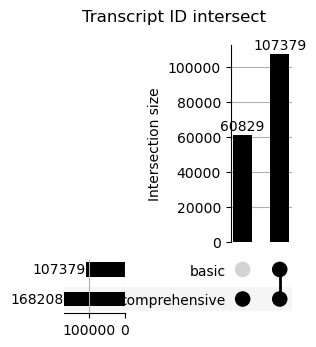

In [9]:
f = pyplot.figure(dpi=100)
f.suptitle('Transcript ID intersect')
_ = upsetplot.plot(upsetplot.from_contents({
    'comprehensive': set(comprehensive['transcript_id']),
    'basic': set(basic['transcript_id']),
}), fig=f, show_counts=True)


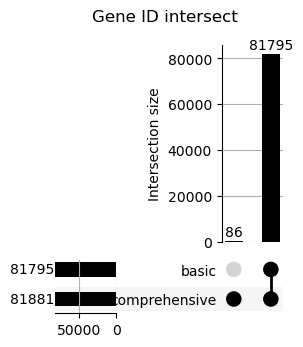

In [15]:
f = pyplot.figure(dpi=100)
f.suptitle('Gene ID intersect')
gene_intersection = upsetplot.from_contents({
    'comprehensive': set(comprehensive['gene_id']),
    'basic': set(basic['gene_id']),
})
_ = upsetplot.plot(gene_intersection, fig=f, show_counts=True)


In [24]:
set(comprehensive[comprehensive['gene_id'].isin(gene_intersection.loc[(True,False)]['id'])]['chromosome'])

<ipython-input-24-c91fe0bcc6b7>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  set(comprehensive[comprehensive['gene_id'].isin(gene_intersection.loc[(True,False)]['id'])]['chromosome'])


{'chr1_GL456210_random',
 'chr1_GL456211_random',
 'chr1_GL456212_random',
 'chr1_GL456221_random',
 'chr4_GL456216_random',
 'chr4_GL456350_random',
 'chr4_JH584292_random',
 'chr4_JH584293_random',
 'chr4_JH584294_random',
 'chr4_JH584295_random',
 'chr5_GL456354_random',
 'chr5_JH584296_random',
 'chr5_JH584297_random',
 'chr5_JH584298_random',
 'chr5_JH584299_random',
 'chr7_GL456219_random',
 'chrUn_GL456239',
 'chrUn_GL456372',
 'chrUn_GL456381',
 'chrUn_GL456385',
 'chrUn_JH584304',
 'chrX_GL456233_random',
 'chrY_JH584303_random'}

Ah. apparently there are few genes on the unknown contigs. I did download just the "chr" set for basic and not the "all" set. so that explains the difference.

In [30]:
comprehensive_transcript_count = comprehensive[comprehensive['type'] == 'transcript'].groupby('gene_id')['transcript_id'].count()
basic_transcript_count = basic[basic['type'] == 'transcript'].groupby('gene_id')['transcript_id'].count()

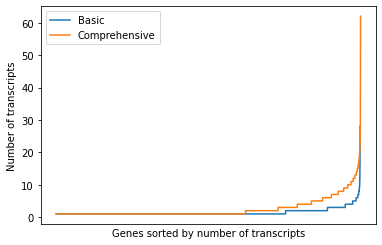

In [47]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.plot(range(basic_transcript_count.shape[0]), basic_transcript_count.sort_values(), label='Basic')
ax.plot(range(comprehensive_transcript_count.shape[0]),comprehensive_transcript_count.sort_values(), label='Comprehensive')
ax.set_ylabel('Number of transcripts')
ax.set_xticks([])
ax.set_xlabel('Genes sorted by number of transcripts')
ax.legend()
#basic_transcript_count.sort_values().plot(ax=ax)
#comprehensive_transcript_count.sort_values().T.plot(ax=ax)
pass

Fraction of annotations with 

In [53]:
basic_transcript_count[basic_transcript_count == 1].shape[0] / basic_transcript_count.shape[0]

0.7547339945897205

In [54]:
comprehensive_transcript_count[comprehensive_transcript_count == 1].shape[0] / comprehensive_transcript_count.shape[0]

0.622154998559493

In [59]:
basic.columns

Index(['chromosome', 'source', 'type', 'start', 'stop', 'score', 'strand',
       'frame', 'gene_id', 'transcript_id', 'gene_type', 'gene_name',
       'transcript_type', 'transcript_name', 'level', 'havana_gene',
       'transcript_support_level', 'tag', 'havana_transcript', 'exon_number',
       'exon_id', 'protein_id', 'ccdsid', 'ont'],
      dtype='object')

In [151]:
basic['feature_length'] = basic['stop'] - basic['start']

transcript_lengths = basic[basic['type'].isin(('exon', 'tRNA'))].groupby('transcript_id')['feature_length'].sum().to_dict()
basic['transcript_length'] = numpy.nan
basic['transcript_length'] = basic[basic['type'].isin(('transcript', 'tRNA')) | (basic['source'] == 'spikein')]['transcript_id'].apply(lambda transcript_id: transcript_lengths.get(transcript_id, numpy.nan))

gene_lengths = basic.groupby('gene_id')['transcript_length'].max().to_dict()
basic['gene_length'] = numpy.nan
basic['gene_length'] = basic[basic['type'].isin(('gene', 'tRNA'))| (basic['source'] == 'spikein')]['gene_id'].apply(lambda gene_id: gene_lengths.get(gene_id, numpy.nan))

In [153]:
basic[['gene_id', 'transcript_id', 'gene_length', 'transcript_length', 'feature_length']].head()

,gene_id,transcript_id,gene_length,transcript_length,feature_length
0,896,896,72.0,72.0,72
1,897,897,75.0,75.0,75
2,1275,1275,70.0,70.0,70
3,1914,1914,72.0,72.0,72
4,1915,1915,74.0,74.0,74


In [154]:
basic[['gene_id', 'transcript_id', 'gene_length', 'transcript_length', 'feature_length']].loc[30000:30100]

,gene_id,transcript_id,gene_length,transcript_length,feature_length
30000,ENSMUSG00000043716.13,ENSMUST00000058437.13,NaN,NaN,137
30001,ENSMUSG00000043716.13,ENSMUST00000058437.13,NaN,NaN,109
30002,ENSMUSG00000043716.13,ENSMUST00000058437.13,NaN,NaN,109
30003,ENSMUSG00000043716.13,ENSMUST00000058437.13,NaN,NaN,209
30004,ENSMUSG00000043716.13,ENSMUST00000058437.13,NaN,NaN,205
...,...,...,...,...,...
30096,ENSMUSG00000025920.19,ENSMUST00000054668.12,NaN,NaN,88
30097,ENSMUSG00000025920.19,ENSMUST00000054668.12,NaN,NaN,1065
30098,ENSMUSG00000025920.19,ENSMUST00000054668.12,NaN,NaN,90
30099,ENSMUSG00000025920.19,ENSMUST00000054668.12,NaN,NaN,2


In [155]:
basic[['gene_id', 'type', 'transcript_id', 'gene_length', 'transcript_length', 'feature_length']].tail(96)

,gene_id,type,transcript_id,gene_length,transcript_length,feature_length
1310894,gSpikein_ERCC-00003,exon,tSpikein_ERCC-00003,1022.0,1022.0,1022
1310895,gSpikein_ERCC-00004,exon,tSpikein_ERCC-00004,522.0,522.0,522
1310896,gSpikein_ERCC-00007,exon,tSpikein_ERCC-00007,1134.0,1134.0,1134
1310897,gSpikein_ERCC-00009,exon,tSpikein_ERCC-00009,983.0,983.0,983
1310898,gSpikein_ERCC-00012,exon,tSpikein_ERCC-00012,993.0,993.0,993
...,...,...,...,...,...,...
1310985,gSpikein_ERCC-00165,exon,tSpikein_ERCC-00165,871.0,871.0,871
1310986,gSpikein_ERCC-00168,exon,tSpikein_ERCC-00168,1023.0,1023.0,1023
1310987,gSpikein_ERCC-00170,exon,tSpikein_ERCC-00170,1022.0,1022.0,1022
1310988,gSpikein_ERCC-00171,exon,tSpikein_ERCC-00171,504.0,504.0,504


In [156]:
basic[basic['gene_id'] == 'ENSMUSG00000051951.5']

,chromosome,source,type,start,stop,score,strand,frame,gene_id,transcript_id,...,tag,havana_transcript,exon_number,exon_id,protein_id,ccdsid,ont,feature_length,transcript_length,gene_length
26254,chr1,HAVANA,gene,3205901,3671498,NaN,-1,NaN,ENSMUSG00000051951.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,465597,NaN,3631.0
26255,chr1,HAVANA,transcript,3214482,3671498,NaN,-1,NaN,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,CCDS,OTTMUST00000065166.1,NaN,NaN,ENSMUSP00000070648.4,CCDS14803.1,NaN,457016,3631.0,NaN
26256,chr1,HAVANA,exon,3670552,3671498,NaN,-1,NaN,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,CCDS,OTTMUST00000065166.1,1.0,ENSMUSE00000485541.3,ENSMUSP00000070648.4,CCDS14803.1,NaN,946,NaN,NaN
26257,chr1,HAVANA,CDS,3670552,3671348,NaN,-1,0.0,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,CCDS,OTTMUST00000065166.1,1.0,ENSMUSE00000485541.3,ENSMUSP00000070648.4,CCDS14803.1,NaN,796,NaN,NaN
26258,chr1,HAVANA,start_codon,3671346,3671348,NaN,-1,0.0,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,CCDS,OTTMUST00000065166.1,1.0,ENSMUSE00000485541.3,ENSMUSP00000070648.4,CCDS14803.1,NaN,2,NaN,NaN
26259,chr1,HAVANA,exon,3421702,3421901,NaN,-1,NaN,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,CCDS,OTTMUST00000065166.1,2.0,ENSMUSE00000449517.3,ENSMUSP00000070648.4,CCDS14803.1,NaN,199,NaN,NaN
26260,chr1,HAVANA,CDS,3421702,3421901,NaN,-1,1.0,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,CCDS,OTTMUST00000065166.1,2.0,ENSMUSE00000449517.3,ENSMUSP00000070648.4,CCDS14803.1,NaN,199,NaN,NaN
26261,chr1,HAVANA,exon,3214482,3216968,NaN,-1,NaN,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,CCDS,OTTMUST00000065166.1,3.0,ENSMUSE00000448840.2,ENSMUSP00000070648.4,CCDS14803.1,NaN,2486,NaN,NaN
26262,chr1,HAVANA,CDS,3216025,3216968,NaN,-1,2.0,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,CCDS,OTTMUST00000065166.1,3.0,ENSMUSE00000448840.2,ENSMUSP00000070648.4,CCDS14803.1,NaN,943,NaN,NaN
26263,chr1,HAVANA,stop_codon,3216022,3216024,NaN,-1,0.0,ENSMUSG00000051951.5,ENSMUST00000070533.4,...,CCDS,OTTMUST00000065166.1,3.0,ENSMUSE00000448840.2,ENSMUSP00000070648.4,CCDS14803.1,NaN,2,NaN,NaN


In [140]:
basic[(basic['gene_id'] == 'ENSMUSG00000025920.19') & (basic['type'] == 'exon')]

,chromosome,source,type,start,stop,score,strand,frame,gene_id,transcript_id,...,tag,havana_transcript,exon_number,exon_id,protein_id,ccdsid,ont,feature_length,transcript_length,gene_length
30038,chr1,HAVANA,exon,16519173,16519306,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000162751.7,...,CCDS,OTTMUST00000082849.3,1.0,ENSMUSE00000862448.1,ENSMUSP00000124505.1,CCDS14831.2,NaN,133,NaN,NaN
30039,chr1,HAVANA,exon,16509342,16509408,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000162751.7,...,CCDS,OTTMUST00000082849.3,2.0,ENSMUSE00001243063.1,ENSMUSP00000124505.1,CCDS14831.2,NaN,66,NaN,NaN
30040,chr1,HAVANA,exon,16486020,16486150,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000162751.7,...,CCDS,OTTMUST00000082849.3,3.0,ENSMUSE00000443692.3,ENSMUSP00000124505.1,CCDS14831.2,NaN,130,NaN,NaN
30043,chr1,HAVANA,exon,16463035,16463194,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000162751.7,...,CCDS,OTTMUST00000082849.3,4.0,ENSMUSE00001343131.1,ENSMUSP00000124505.1,CCDS14831.2,NaN,159,NaN,NaN
30045,chr1,HAVANA,exon,16440323,16440458,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000162751.7,...,CCDS,OTTMUST00000082849.3,5.0,ENSMUSE00001299794.1,ENSMUSP00000124505.1,CCDS14831.2,NaN,135,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30369,chr1,HAVANA,exon,16520001,16520020,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000144138.3,...,basic,OTTMUST00000086845.1,1.0,ENSMUSE00000850866.1,ENSMUSP00000119130.2,NaN,NaN,19,NaN,NaN
30370,chr1,HAVANA,exon,16509342,16509408,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000144138.3,...,basic,OTTMUST00000086845.1,2.0,ENSMUSE00001243063.1,ENSMUSP00000119130.2,NaN,NaN,66,NaN,NaN
30371,chr1,HAVANA,exon,16486020,16486150,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000144138.3,...,basic,OTTMUST00000086845.1,3.0,ENSMUSE00000443692.3,ENSMUSP00000119130.2,NaN,NaN,130,NaN,NaN
30374,chr1,HAVANA,exon,16463035,16463194,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000144138.3,...,basic,OTTMUST00000086845.1,4.0,ENSMUSE00001343131.1,ENSMUSP00000119130.2,NaN,NaN,159,NaN,NaN


In [158]:
import random
random.choice(basic['gene_id'])

'ENSMUSG00000022973.18'

In [161]:
basic[(basic['gene_id'] == 'ENSMUSG00000022973.18')]

,chromosome,source,type,start,stop,score,strand,frame,gene_id,transcript_id,...,tag,havana_transcript,exon_number,exon_id,protein_id,ccdsid,ont,feature_length,transcript_length,gene_length
1108087,chr16,HAVANA,gene,90936092,91011308,NaN,-1,NaN,ENSMUSG00000022973.18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75216,NaN,7058.0
1108088,chr16,HAVANA,transcript,90936092,91011308,NaN,-1,NaN,ENSMUSG00000022973.18,ENSMUST00000121759.7,...,CCDS,OTTMUST00000069191.4,NaN,NaN,ENSMUSP00000113308.1,CCDS49907.1,NaN,75216,7058.0,NaN
1108089,chr16,HAVANA,exon,91011093,91011308,NaN,-1,NaN,ENSMUSG00000022973.18,ENSMUST00000121759.7,...,CCDS,OTTMUST00000069191.4,1.0,ENSMUSE00000713699.1,ENSMUSP00000113308.1,CCDS49907.1,NaN,215,NaN,NaN
1108090,chr16,HAVANA,CDS,91011093,91011190,NaN,-1,0.0,ENSMUSG00000022973.18,ENSMUST00000121759.7,...,CCDS,OTTMUST00000069191.4,1.0,ENSMUSE00000713699.1,ENSMUSP00000113308.1,CCDS49907.1,NaN,97,NaN,NaN
1108091,chr16,HAVANA,start_codon,91011188,91011190,NaN,-1,0.0,ENSMUSG00000022973.18,ENSMUST00000121759.7,...,CCDS,OTTMUST00000069191.4,1.0,ENSMUSE00000713699.1,ENSMUSP00000113308.1,CCDS49907.1,NaN,2,NaN,NaN
1108092,chr16,HAVANA,exon,91010024,91010169,NaN,-1,NaN,ENSMUSG00000022973.18,ENSMUST00000121759.7,...,CCDS,OTTMUST00000069191.4,2.0,ENSMUSE00001212490.1,ENSMUSP00000113308.1,CCDS49907.1,NaN,145,NaN,NaN
1108093,chr16,HAVANA,CDS,91010024,91010169,NaN,-1,1.0,ENSMUSG00000022973.18,ENSMUST00000121759.7,...,CCDS,OTTMUST00000069191.4,2.0,ENSMUSE00001212490.1,ENSMUSP00000113308.1,CCDS49907.1,NaN,145,NaN,NaN
1108094,chr16,HAVANA,exon,90993941,90994027,NaN,-1,NaN,ENSMUSG00000022973.18,ENSMUST00000121759.7,...,CCDS,OTTMUST00000069191.4,3.0,ENSMUSE00001237810.1,ENSMUSP00000113308.1,CCDS49907.1,NaN,86,NaN,NaN
1108095,chr16,HAVANA,CDS,90993941,90994027,NaN,-1,2.0,ENSMUSG00000022973.18,ENSMUST00000121759.7,...,CCDS,OTTMUST00000069191.4,3.0,ENSMUSE00001237810.1,ENSMUSP00000113308.1,CCDS49907.1,NaN,86,NaN,NaN
1108096,chr16,HAVANA,exon,90991380,90991647,NaN,-1,NaN,ENSMUSG00000022973.18,ENSMUST00000121759.7,...,CCDS,OTTMUST00000069191.4,4.0,ENSMUSE00001229090.1,ENSMUSP00000113308.1,CCDS49907.1,NaN,267,NaN,NaN


In [162]:
basic[(basic['gene_id'] == 'ENSMUSG00000025920.19')]

,chromosome,source,type,start,stop,score,strand,frame,gene_id,transcript_id,...,tag,havana_transcript,exon_number,exon_id,protein_id,ccdsid,ont,feature_length,transcript_length,gene_length
30036,chr1,HAVANA,gene,16228674,16520112,NaN,-1,NaN,ENSMUSG00000025920.19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,291438,NaN,3895.0
30037,chr1,HAVANA,transcript,16228674,16519306,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000162751.7,...,CCDS,OTTMUST00000082849.3,NaN,NaN,ENSMUSP00000124505.1,CCDS14831.2,NaN,290632,3016.0,NaN
30038,chr1,HAVANA,exon,16519173,16519306,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000162751.7,...,CCDS,OTTMUST00000082849.3,1.0,ENSMUSE00000862448.1,ENSMUSP00000124505.1,CCDS14831.2,NaN,133,NaN,NaN
30039,chr1,HAVANA,exon,16509342,16509408,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000162751.7,...,CCDS,OTTMUST00000082849.3,2.0,ENSMUSE00001243063.1,ENSMUSP00000124505.1,CCDS14831.2,NaN,66,NaN,NaN
30040,chr1,HAVANA,exon,16486020,16486150,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000162751.7,...,CCDS,OTTMUST00000082849.3,3.0,ENSMUSE00000443692.3,ENSMUSP00000124505.1,CCDS14831.2,NaN,130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30378,chr1,HAVANA,stop_codon,16460316,16460318,NaN,-1,0.0,ENSMUSG00000025920.19,ENSMUST00000144138.3,...,basic,OTTMUST00000086845.1,5.0,ENSMUSE00000859196.1,ENSMUSP00000119130.2,NaN,NaN,2,NaN,NaN
30379,chr1,HAVANA,UTR,16520001,16520020,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000144138.3,...,basic,OTTMUST00000086845.1,1.0,ENSMUSE00000850866.1,ENSMUSP00000119130.2,NaN,NaN,19,NaN,NaN
30380,chr1,HAVANA,UTR,16509342,16509408,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000144138.3,...,basic,OTTMUST00000086845.1,2.0,ENSMUSE00001243063.1,ENSMUSP00000119130.2,NaN,NaN,66,NaN,NaN
30381,chr1,HAVANA,UTR,16486134,16486150,NaN,-1,NaN,ENSMUSG00000025920.19,ENSMUST00000144138.3,...,basic,OTTMUST00000086845.1,3.0,ENSMUSE00000443692.3,ENSMUSP00000119130.2,NaN,NaN,16,NaN,NaN
